In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import pgzip as gz
import _pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [4]:
with gz.open('TR_DATA/data_X2.pkl.gz') as f:
    NP_gene = pkl.load(f)

### Normalize gene exp

In [69]:
NP_norm = NP_gene - NP_gene.min(axis=1, keepdims=True)

In [117]:
#sns.distplot(NP_norm.flatten())

In [118]:
def set_random_seed(name):

    import hashlib
    seed_sha = int(hashlib.sha256(model_id.encode('utf-8')).hexdigest(), 16) % 1000000

    np.random.seed(seed_sha)
    tf.random.set_seed(seed_sha+1)

In [72]:
model_id = 'model_epiprex_0611'
set_random_seed(model_id)

In [73]:
batch_size = 256
epochs = 2000
learning_rate = 2e-3

In [74]:
size_input = NP_norm.shape[0]
size_latent = 40

In [75]:
class DenseLayers(tf.keras.layers.Layer):
    def __init__(self, layer_params):
        super(DenseLayers, self).__init__()
        
        L_layer = list()
   
        for x in layer_params:
            if x<1:
                l1 = Dropout(rate=x)
            else:
                l1 = Dense( x, activation=tf.nn.relu, kernel_initializer='GlorotNormal')
            L_layer.append( l1 )

        self.hidden_layer = L_layer

    def call(self, input_features):
        x = input_features
        for l1 in self.hidden_layer:
            x = l1(x)
        return x

In [76]:
class zScoreLayer(tf.keras.layers.Layer):
    def call(self, a):
        σ = tf.math.reduce_std (a, axis=0, keepdims=True)
        μ = tf.math.reduce_mean(a, axis=0, keepdims=True)
        Z = (a-μ)/(σ+0.001)
        Z_trunc = tf.math.minimum(tf.math.maximum(Z, -8), 8)
        
        return Z_trunc

In [77]:
class GeneEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneEncoder, self).__init__()

        layer_params = [0.4, 512, #0.3, 1024,
                        0.5, 128, #0.2, 32,
                        0.1]
        
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_latent, activation=tf.nn.sigmoid, kernel_initializer='GlorotNormal' )
        self.normal_layer = zScoreLayer() #BatchNormalization()
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        x = self.output_layer(x)
        return self.normal_layer(x)

In [78]:
def act_relu1(x):
    r = tf.minimum(tf.maximum(x, 0), 1)
    return r

In [79]:
class GeneDecoder(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneDecoder, self).__init__()

        layer_params = [128, 256, 512, 1024]
        
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_input, activation=act_relu1, kernel_initializer='GlorotNormal'  )

    def call(self, input_features):
        x = self.hidden_layer(input_features)
        return self.output_layer(x)

In [80]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = GeneEncoder()
        self.decoder = GeneDecoder()

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed
    
    @tf.function
    def encoded(self, input_features):
        encoded = self.encoder(input_features)
        return encoded

In [81]:
autoencoder = Autoencoder()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [82]:
TR_X_gene = NP_norm.T.astype('float32')
TR_X_gene_0 = TR_X_gene < 0.2
TR_X_gene_mu0 = TR_X_gene_0.mean(axis=0, keepdims=True).astype('float32')
TR_X_gene_mu1 = TR_X_gene_0.mean(axis=1, keepdims=True).astype('float32')

In [84]:
TR_X_gene_w0_0 = 1/TR_X_gene_mu0
TR_X_gene_w0_1 = 1/(1-TR_X_gene_mu0)

TR_X_gene_w1_0 = 1/TR_X_gene_mu1
TR_X_gene_w1_1 = 1/(1-TR_X_gene_mu1)

In [85]:
def loss(model, dataset):
    data, w1_0, w1_1 = dataset
    pred = model(data)

    zeros = tf.cast(data<0.1, tf.float32)
    weight0 = (w1_0 + TR_X_gene_w0_0) * zeros
    weight1 = (w1_1 + TR_X_gene_w0_1) * (1-zeros)
    
    sse0 = tf.math.reduce_mean( tf.math.square(pred)      * weight0)
    sse1 = tf.math.reduce_mean( tf.math.square(pred-data) * weight1)
    
    return sse0 + sse1

def train(loss, model, opt, dataset):
    data, w1_0, w1_1 = dataset

    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, dataset), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

In [87]:
tr_data = tf.data.Dataset.from_tensor_slices(TR_X_gene)
tr_w1_0 = tf.data.Dataset.from_tensor_slices(TR_X_gene_w1_0)
tr_w1_1 = tf.data.Dataset.from_tensor_slices(TR_X_gene_w1_1)

training_dataset = tf.data.Dataset.zip((tr_data, tr_w1_0, tr_w1_1))
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(NP_norm.T.shape[0])
training_dataset = training_dataset.prefetch(batch_size * 4)

In [88]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
        
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        
        epoch_loss.append( loss_values )
    loss_sum = np.array(epoch_loss).mean()
    l_loss.append(loss_sum)
    print('Epoch %d/%d' %(epoch, epochs), loss_sum)

Epoch 0/2000 0.6697872
Epoch 1/2000 0.57094353
Epoch 2/2000 0.60281533
Epoch 3/2000 0.5343568
Epoch 4/2000 0.4898023
Epoch 5/2000 0.45010215
Epoch 6/2000 0.41428223
Epoch 7/2000 0.4020873
Epoch 8/2000 0.39915222
Epoch 9/2000 0.38711715
Epoch 10/2000 0.38715363
Epoch 11/2000 0.37738198
Epoch 12/2000 0.3749283
Epoch 13/2000 0.36967528
Epoch 14/2000 0.3643428
Epoch 15/2000 0.36092854
Epoch 16/2000 0.35638246
Epoch 17/2000 0.3526798
Epoch 18/2000 0.3479066
Epoch 19/2000 0.3449064
Epoch 20/2000 0.3409687
Epoch 21/2000 0.3373931
Epoch 22/2000 0.3350329
Epoch 23/2000 0.33190584
Epoch 24/2000 0.32966867
Epoch 25/2000 0.32754683
Epoch 26/2000 0.32514128
Epoch 27/2000 0.32323855
Epoch 28/2000 0.32105458
Epoch 29/2000 0.31913304
Epoch 30/2000 0.31705606
Epoch 31/2000 0.31480998
Epoch 32/2000 0.31306076
Epoch 33/2000 0.3108704
Epoch 34/2000 0.30886048
Epoch 35/2000 0.3069836
Epoch 36/2000 0.30480945
Epoch 37/2000 0.30307114
Epoch 38/2000 0.3009386
Epoch 39/2000 0.29894716
Epoch 40/2000 0.2970915
E

Epoch 321/2000 0.02284615
Epoch 322/2000 0.022823794
Epoch 323/2000 0.02279454
Epoch 324/2000 0.022732722
Epoch 325/2000 0.02260814
Epoch 326/2000 0.022529714
Epoch 327/2000 0.022491595
Epoch 328/2000 0.022537334
Epoch 329/2000 0.022648022
Epoch 330/2000 0.022846077
Epoch 331/2000 0.023106825
Epoch 332/2000 0.023607308
Epoch 333/2000 0.024309803
Epoch 334/2000 0.025442606
Epoch 335/2000 0.028268171
Epoch 336/2000 0.0383882
Epoch 337/2000 0.053774986
Epoch 338/2000 0.034034006
Epoch 339/2000 0.08507238
Epoch 340/2000 0.04598773
Epoch 341/2000 0.056557134
Epoch 342/2000 0.062361144
Epoch 343/2000 0.042690363
Epoch 344/2000 0.05266252
Epoch 345/2000 0.05932962
Epoch 346/2000 0.045059748
Epoch 347/2000 0.04185105
Epoch 348/2000 0.045081478
Epoch 349/2000 0.04174954
Epoch 350/2000 0.037094444
Epoch 351/2000 0.037680626
Epoch 352/2000 0.034384575
Epoch 353/2000 0.03457553
Epoch 354/2000 0.032965552
Epoch 355/2000 0.03140456
Epoch 356/2000 0.03096045
Epoch 357/2000 0.030208362
Epoch 358/2000 

Epoch 633/2000 0.019743616
Epoch 634/2000 0.019743524
Epoch 635/2000 0.019743435
Epoch 636/2000 0.019743348
Epoch 637/2000 0.019743264
Epoch 638/2000 0.019743178
Epoch 639/2000 0.019743094
Epoch 640/2000 0.019743012
Epoch 641/2000 0.019742934
Epoch 642/2000 0.019742852
Epoch 643/2000 0.019742774
Epoch 644/2000 0.019742696
Epoch 645/2000 0.019742621
Epoch 646/2000 0.019742547
Epoch 647/2000 0.019742476
Epoch 648/2000 0.019742403
Epoch 649/2000 0.019742332
Epoch 650/2000 0.019742263
Epoch 651/2000 0.019742193
Epoch 652/2000 0.019742126
Epoch 653/2000 0.019742059
Epoch 654/2000 0.019741993
Epoch 655/2000 0.01974193
Epoch 656/2000 0.019741867
Epoch 657/2000 0.019741807
Epoch 658/2000 0.019741744
Epoch 659/2000 0.019741684
Epoch 660/2000 0.019741556
Epoch 661/2000 0.019741397
Epoch 662/2000 0.01974126
Epoch 663/2000 0.019741159
Epoch 664/2000 0.019741103
Epoch 665/2000 0.019741062
Epoch 666/2000 0.019741025
Epoch 667/2000 0.01974097
Epoch 668/2000 0.019740906
Epoch 669/2000 0.01974084
Epoch

Epoch 940/2000 0.019569062
Epoch 941/2000 0.019568594
Epoch 942/2000 0.019568296
Epoch 943/2000 0.019568168
Epoch 944/2000 0.019567788
Epoch 945/2000 0.019567642
Epoch 946/2000 0.019567389
Epoch 947/2000 0.019567208
Epoch 948/2000 0.019566987
Epoch 949/2000 0.019566871
Epoch 950/2000 0.019566614
Epoch 951/2000 0.01956653
Epoch 952/2000 0.019566357
Epoch 953/2000 0.019566193
Epoch 954/2000 0.019566111
Epoch 955/2000 0.019565929
Epoch 956/2000 0.019565849
Epoch 957/2000 0.019565728
Epoch 958/2000 0.019565608
Epoch 959/2000 0.019565519
Epoch 960/2000 0.019565418
Epoch 961/2000 0.019565314
Epoch 962/2000 0.019565249
Epoch 963/2000 0.019565143
Epoch 964/2000 0.019565072
Epoch 965/2000 0.019564996
Epoch 966/2000 0.019564912
Epoch 967/2000 0.019564858
Epoch 968/2000 0.019564776
Epoch 969/2000 0.019564722
Epoch 970/2000 0.019564653
Epoch 971/2000 0.019564595
Epoch 972/2000 0.019564541
Epoch 973/2000 0.019564481
Epoch 974/2000 0.019564435
Epoch 975/2000 0.019564379
Epoch 976/2000 0.019564336
Ep

Epoch 1239/2000 0.01955528
Epoch 1240/2000 0.01955528
Epoch 1241/2000 0.01955528
Epoch 1242/2000 0.01955528
Epoch 1243/2000 0.01955528
Epoch 1244/2000 0.01955528
Epoch 1245/2000 0.019555276
Epoch 1246/2000 0.019555276
Epoch 1247/2000 0.019555276
Epoch 1248/2000 0.019555276
Epoch 1249/2000 0.019555276
Epoch 1250/2000 0.019555276
Epoch 1251/2000 0.019555276
Epoch 1252/2000 0.019555276
Epoch 1253/2000 0.019555276
Epoch 1254/2000 0.019555276
Epoch 1255/2000 0.019555276
Epoch 1256/2000 0.019555276
Epoch 1257/2000 0.019555276
Epoch 1258/2000 0.019555273
Epoch 1259/2000 0.019555273
Epoch 1260/2000 0.019555273
Epoch 1261/2000 0.019555273
Epoch 1262/2000 0.019555273
Epoch 1263/2000 0.019555273
Epoch 1264/2000 0.019555273
Epoch 1265/2000 0.019555273
Epoch 1266/2000 0.019555273
Epoch 1267/2000 0.019555273
Epoch 1268/2000 0.019555273
Epoch 1269/2000 0.019555273
Epoch 1270/2000 0.019555273
Epoch 1271/2000 0.019555273
Epoch 1272/2000 0.019555273
Epoch 1273/2000 0.019555273
Epoch 1274/2000 0.01955527

Epoch 1534/2000 0.0194229
Epoch 1535/2000 0.019421792
Epoch 1536/2000 0.01942193
Epoch 1537/2000 0.01942129
Epoch 1538/2000 0.019420905
Epoch 1539/2000 0.019420536
Epoch 1540/2000 0.019420356
Epoch 1541/2000 0.019420171
Epoch 1542/2000 0.019419642
Epoch 1543/2000 0.019419659
Epoch 1544/2000 0.01941931
Epoch 1545/2000 0.01941928
Epoch 1546/2000 0.019418983
Epoch 1547/2000 0.019418834
Epoch 1548/2000 0.019418709
Epoch 1549/2000 0.019418638
Epoch 1550/2000 0.01941847
Epoch 1551/2000 0.019418322
Epoch 1552/2000 0.019418305
Epoch 1553/2000 0.019418148
Epoch 1554/2000 0.019418124
Epoch 1555/2000 0.019417992
Epoch 1556/2000 0.019417927
Epoch 1557/2000 0.019417899
Epoch 1558/2000 0.019417815
Epoch 1559/2000 0.019417768
Epoch 1560/2000 0.019417692
Epoch 1561/2000 0.019417679
Epoch 1562/2000 0.019417617
Epoch 1563/2000 0.0194176
Epoch 1564/2000 0.01941753
Epoch 1565/2000 0.01941752
Epoch 1566/2000 0.019417485
Epoch 1567/2000 0.019417463
Epoch 1568/2000 0.019417426
Epoch 1569/2000 0.019417403
Epo

Epoch 1832/2000 0.019407623
Epoch 1833/2000 0.01940762
Epoch 1834/2000 0.01940763
Epoch 1835/2000 0.019407626
Epoch 1836/2000 0.019407611
Epoch 1837/2000 0.019407613
Epoch 1838/2000 0.019407619
Epoch 1839/2000 0.019407615
Epoch 1840/2000 0.019407606
Epoch 1841/2000 0.019407606
Epoch 1842/2000 0.019407608
Epoch 1843/2000 0.019407606
Epoch 1844/2000 0.019407602
Epoch 1845/2000 0.019407602
Epoch 1846/2000 0.019407602
Epoch 1847/2000 0.019407602
Epoch 1848/2000 0.019407598
Epoch 1849/2000 0.019407598
Epoch 1850/2000 0.019407598
Epoch 1851/2000 0.019407598
Epoch 1852/2000 0.019407595
Epoch 1853/2000 0.019407595
Epoch 1854/2000 0.019407595
Epoch 1855/2000 0.019407595
Epoch 1856/2000 0.019407593
Epoch 1857/2000 0.019407593
Epoch 1858/2000 0.019407595
Epoch 1859/2000 0.01940759
Epoch 1860/2000 0.01940759
Epoch 1861/2000 0.01940759
Epoch 1862/2000 0.01940759
Epoch 1863/2000 0.01940759
Epoch 1864/2000 0.01940759
Epoch 1865/2000 0.01940759
Epoch 1866/2000 0.01940759
Epoch 1867/2000 0.01940759
Epo

In [90]:
encoded = np.array(autoencoder.encoded(TR_X_gene))

In [91]:
with gz.open('TR_DATA/data_X2_enc.pkl.gz', 'wb') as f:
    pkl.dump(encoded, f)

## Result

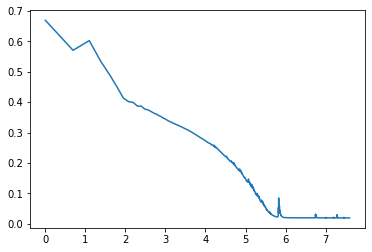

In [109]:
sns.lineplot(np.log(np.arange(len(l_loss))+1), l_loss)

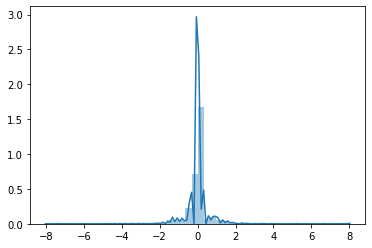

In [110]:
sns.distplot(np.array(encoded).flatten())

In [111]:
pred_data = TR_X_gene[:200].astype('float32')
recv_data = np.array(autoencoder(pred_data))

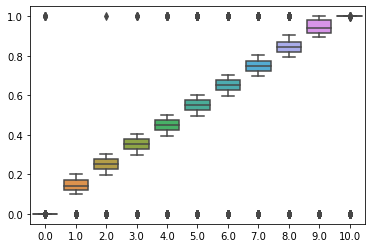

In [112]:
sns.boxplot( (pred_data.flatten()*10)//1, recv_data.flatten() )

In [113]:
def draw_images():

    pr100 = pred_data[:100,:200]
    re100 = recv_data[:100,:200]
    merged = np.concatenate( (pr100, re100) )
    plt.imshow(merged)
    plt.show()
    
    plt.imshow((pr100-re100))
    plt.show()


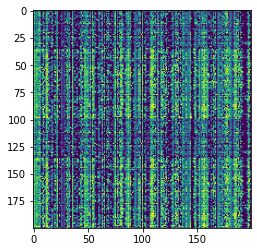

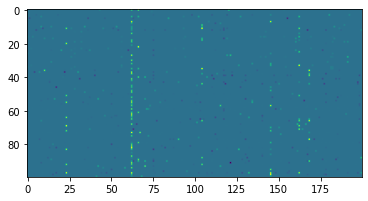

In [114]:
draw_images()

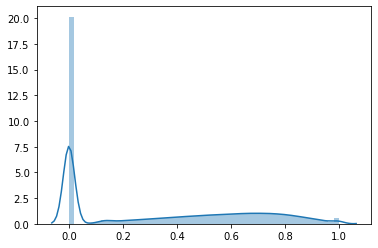

In [115]:
sns.distplot(pred_data.flatten())

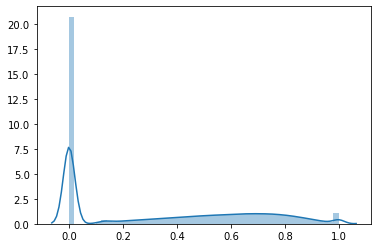

In [116]:
sns.distplot(recv_data.flatten())